# `FL003_tuning_curves`

Technically we already added tuning curves in a previous stage (when loading data into nelpy), but here we need to re-estimate tuning curves for both idealized position (in 2D) and linearized position (in 1D, center-outer ordering and outer-outer ordering).

**Update:** we now no longer estimate tuning curves during initial loading into nelpy, so this is the only place where we estimate tuning curves.

**Question:** tuning curves are estimated without ripples. Does this include non-candidate ripples, such as possible theta sequences? I assume so, just want to confirm.

In [1]:
%load_ext watermark
%watermark -a "Etienne Ackermann," -n -t -v -p nelpy,numpy,scipy,pandas

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


Etienne Ackermann, Sat Dec 02 2017 07:22:41 

CPython 3.6.3
IPython 6.1.0

nelpy 0.1.1
numpy 1.12.1
scipy 0.19.1
pandas 0.21.0


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

%matplotlib inline

warnings.filterwarnings("ignore")

C:\Users\etien\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.


In [4]:
fileroot = '../../../../neoReader/'
FrankLabData = nel.load_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg02.nel') # saved with Pandas=0.21
data = FrankLabData.data
sessions = FrankLabData.sessions

In [7]:
def get_TuningCurve1D(st_run_no_ripples, pos):
    """Docstring goes here"""
    
    assert pos.n_signals == 1, "a 1 dimensional AnalogSignalArray was expected!"

    ds_run = 0.5 # 500 ms bins for RUN data
    ds_25ms = 0.025
    sigma_spk = 0.5 # 500 ms spike smoothing
    
    # smooth and re-bin:
    bst_run_no_ripples = st_run_no_ripples.bin(ds=ds_25ms).smooth(sigma=sigma_spk, 
                                                                  inplace=True).rebin(w=round(ds_run/ds_25ms))
    
    extmin, extmax = np.floor(pos.min()/10)*10-1, np.ceil(pos.max()/10)*10+1
    
    n_extern=150
    sigma=0
    
    tc = nel.TuningCurve1D(bst=bst_run_no_ripples,
                           extern=pos,
                           min_duration=0, 
                           n_extern=n_extern, 
                           extmin=extmin, 
                           extmax=extmax, 
                           sigma=sigma)
    return tc

def get_TuningCurve2D(st_run_no_ripples, pos):
    """Docstring goes here"""
    
    assert pos.n_signals == 2, "a 2 dimensional AnalogSignalArray was expected!"
    
    ds_run = 0.5 # 500 ms bins for RUN data
    ds_25ms = 0.025
    sigma_spk = 0.5 # 500 ms spike smoothing
    
    # smooth and re-bin:
    bst_run_no_ripples = st_run_no_ripples.bin(ds=ds_25ms).smooth(sigma=sigma_spk, 
                                                                  inplace=True).rebin(w=round(ds_run/ds_25ms))
    ext_xmin, ext_xmax = np.floor(pos[:,0].min()/10)*10-1, np.ceil(pos[:,0].max()/10)*10+1
    ext_ymin, ext_ymax = np.floor(pos[:,1].min()/10)*10-1, np.ceil(pos[:,1].max()/10)*10+1
    ext_nx=100
    ext_ny=100

    tc2d = nel.TuningCurve2D(bst=bst_run_no_ripples,
                                 extern=pos,
                                 min_duration=0, 
                                 ext_nx=ext_nx, 
                                 ext_ny=ext_ny, 
                                 ext_xmin=ext_xmin, 
                                 ext_xmax=ext_xmax, 
                                 ext_ymin=ext_ymin, 
                                 ext_ymax=ext_ymax)

    tc2d._initialize_mask_from_extern(pos)
    
    return tc2d
    

### Augment data dict with run epochs

**Note:** `run_epochs` are estimated using the raw 2D position-derived speed. Although we can re-estimate run based on the idealized 2D position or the linearized position, I think that it is more principled to keep the `run_epochs` fixed from the 2D raw speed.

From an earlier (not comprehensive, but reasonably good) analysis, we found (v1, v2) = (3, 2.5) cm/s to be good speed thresholds for run.

In [7]:
v1, v2 = 3, 2.5

for animal, day in sessions:
    run_epochs = nel.utils.get_run_epochs(data[animal][day]['speed'], v1=v1, v2=v2)
    data[animal][day]['run_epochs'] = run_epochs    

### Augment data dict with tuning curves

Here we add tuning curves for:
 - the raw 2D position data (`tuning_curves2D`), 
 - the idealized 2D position data (`tuning_curves2D_ideal`), 
 - the center-outer order linearized position data (`tuning_curves1D_center`), and 
 - the outer-outer order linearized position data (`tuning_curves1D_outer`).

**Note:** 2D raw position tuning curves are estimated for ALL task epochs (rest and run), whereas the idealized and linearized versions are only computed for (and indeed, defined for) the task run epochs.

In [8]:
for animal, day in sessions:
    print(animal, day)
    run_epochs = data[animal][day]['run_epochs']
    ripple_epochs = data[animal][day]['ripple_epochs']
    task_run_epoch_IDs = data[animal][day]['task_metadata'].query('type=="run"').Epoch.values.tolist()

    data[animal][day]['tuning_curves2D'] = {}
    data[animal][day]['tuning_curves2D_ideal'] = {}
    data[animal][day]['tuning_curves1D_center'] = {}
    data[animal][day]['tuning_curves1D_outer'] = {}
    
    for epidx, ep in enumerate(data[animal][day]['task_epochs']):
        # get spiketrain for epoch
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            st = data[animal][day]['spikes'][epidx]
        
        if st.isempty: # this is true for Fra Day3 epoch 0
            pass
        else:
            # get spiketrain during run bouts for epoch
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                st_run_no_ripples = st[run_epochs][~ripple_epochs]

            # estimate tuning curves
            pos2d = data[animal][day]['pos'][epidx]
            tc2d = get_TuningCurve2D(st_run_no_ripples, pos2d)
            data[animal][day]['tuning_curves2D'][epidx] = tc2d
            
            if epidx in task_run_epoch_IDs:
                pos2d_ideal = data[animal][day]['pos_ideal'][epidx]
                tc2d_ideal = get_TuningCurve2D(st_run_no_ripples, pos2d_ideal)
                data[animal][day]['tuning_curves2D_ideal'][epidx] = tc2d_ideal

                pos_co = data[animal][day]['pos_linear_center_ordering'][epidx]
                tc_co = get_TuningCurve1D(st_run_no_ripples, pos_co)
                tc_co.reorder_units(inplace=True)
                data[animal][day]['tuning_curves1D_center'][epidx] = tc_co

                pos_oo = data[animal][day]['pos_linear_outer_ordering'][epidx]
                tc_oo = get_TuningCurve1D(st_run_no_ripples, pos_oo)
                tc_oo.reorder_units(inplace=True)
                data[animal][day]['tuning_curves1D_outer'][epidx] = tc_oo         
           

Bon Day2
Bon Day3
Bon Day4
Bon Day5
Bon Day6
Bon Day7
Bon Day8
Bon Day9
Con Day0
Con Day1
Con Day2
Con Day3
Con Day4
Con Day5
Fra Day1
Fra Day2
Fra Day3
Fra Day4
Fra Day5
Fra Day6
Fra Day7
Fra Day8
Fra Day9
Fra Day10
Fra Day11


### Look at a few tuning curves

In [5]:
animal, day = 'Bon', 'Day3'
epidx = 1

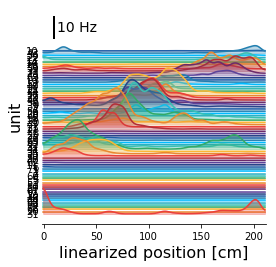

In [6]:
tc = data[animal][day]['tuning_curves1D_center'][epidx].smooth(sigma=4)

with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(4, 4)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)

        npl.plot_tuning_curves1D(tc, ax=ax, pad=1.);

        ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(50, ax)
        npl.add_simple_scalebar("10 Hz", ax=ax, xy=(10, 78.5), length=10, orientation='v', rotation_text='h', size=14)

        ax.set_xlabel('linearized position [cm]', size=16)
        ax.set_ylabel('unit', size=16)
        
#         npl.utils.savefig("bayes_tuningcurves.svg")
        

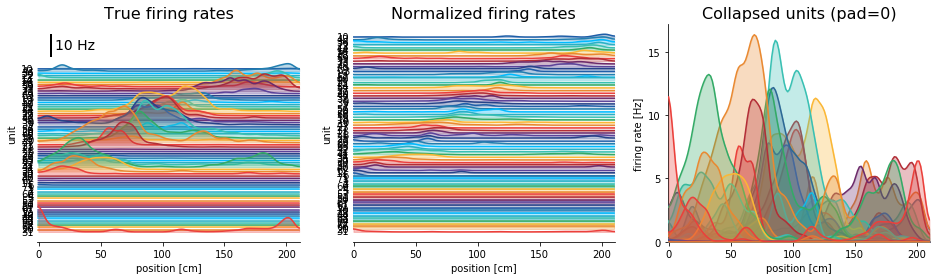

In [12]:
# reorder cells by peak firing location on track (this is nice for visualization, but doesn't affect decoding)
tc = data[animal][day]['tuning_curves1D_center'][epidx].smooth(sigma=4)

# with plt.xkcd():
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, nrows=1, ncols=3, figsize=(16,4)) as (fig, axes):
        npl.utils.skip_if_no_output(fig)
        ax0, ax1, ax2 = axes
        # plot units that passed all criteria for inclusion
        npl.plot_tuning_curves1D(tc, ax=ax0, pad=1.);
        npl.plot_tuning_curves1D(tc, ax=ax1, normalize=True, pad=0.9);
        npl.plot_tuning_curves1D(tc, ax=ax2, pad=0);

#         npl.plot_tuning_curves1D(tc, ax=ax0, pad=1);
#         npl.plot_tuning_curves1D(tc, ax=ax1, pad=0.5);
#         npl.plot_tuning_curves1D(tc, ax=ax2, pad=0);
        for ax in axes:
            ax.set_xlabel('position [cm]')
        npl.utils.xticks_interval(50, *axes)
        npl.utils.yticks_interval(5, ax2)
        npl.add_simple_scalebar("10 Hz", ax=ax0, xy=(10, 78.5), length=10, orientation='v', rotation_text='h', size=14)
#         npl.add_simple_scalebar("5 Hz", ax=ax1, xy=(10, 17.5), length=5, orientation='v', rotation_text='h', size=14)
        ax0.set_title('True firing rates', size=16)
        ax1.set_title('Normalized firing rates', size=16)
        ax2.set_title('Collapsed units (pad=0)', size=16)

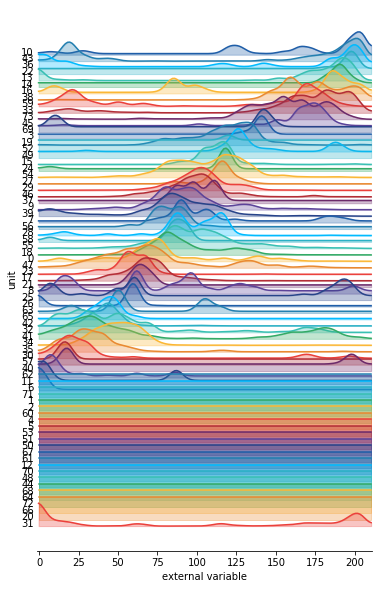

In [34]:
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(6,10)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)
        npl.plot_tuning_curves1D(data[animal][day]['tuning_curves1D_center'][epidx].smooth(sigma=4), ax=ax, normalize=True);

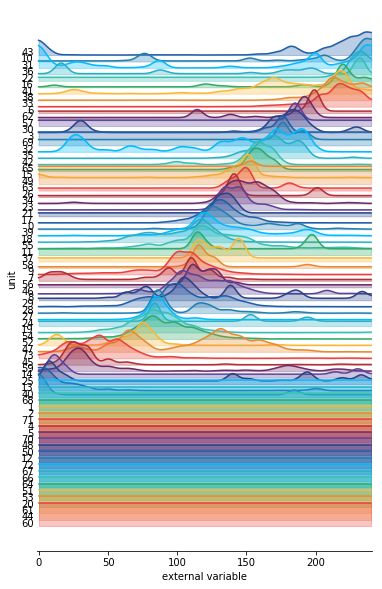

In [47]:
with npl.palettes.color_palette(npl.colors.rainbow):
    with npl.FigureManager(show=True, figsize=(6,10)) as (fig, ax):
        npl.utils.skip_if_no_output(fig)
        npl.plot_tuning_curves1D(data[animal][day]['tuning_curves1D_outer'][epidx].smooth(sigma=4), ax=ax, normalize=True);

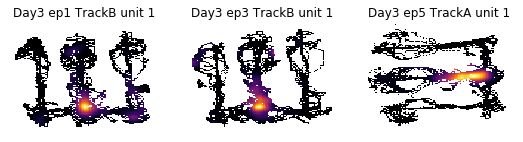

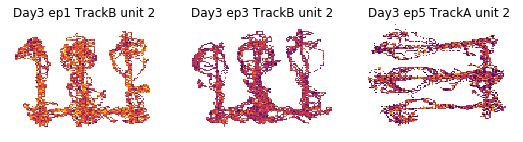

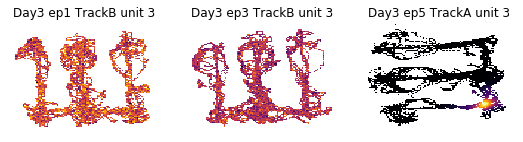

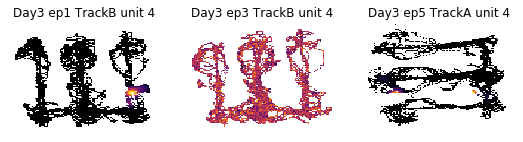

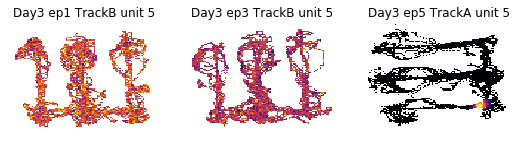

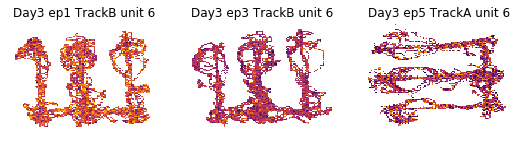

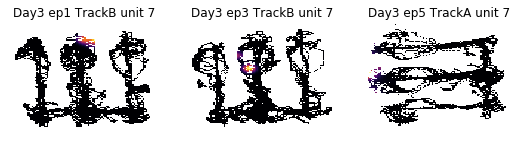

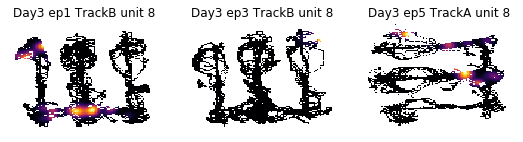

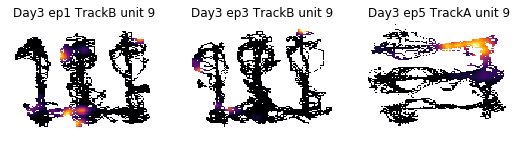

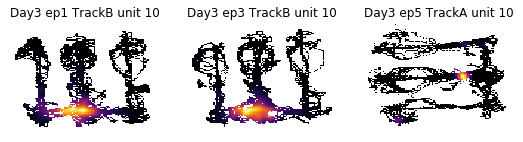

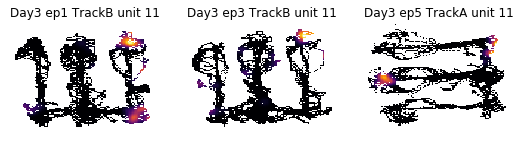

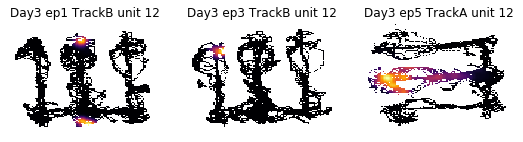

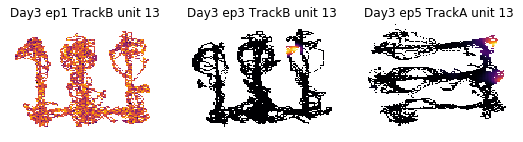

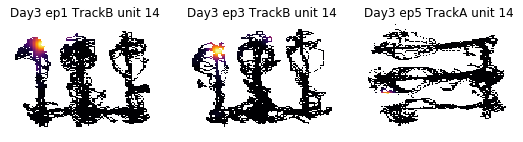

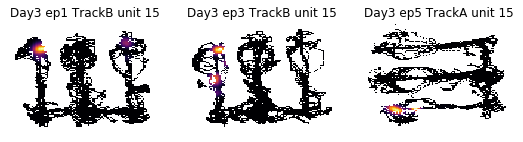

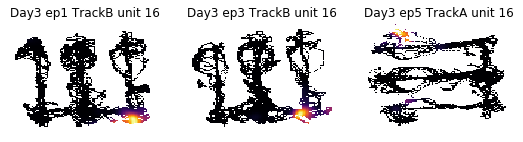

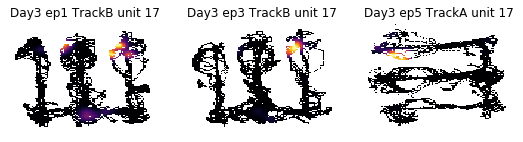

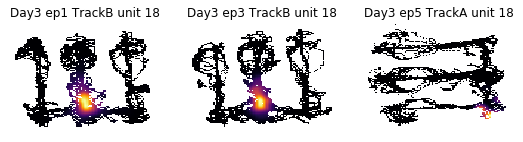

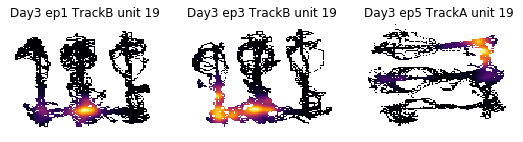

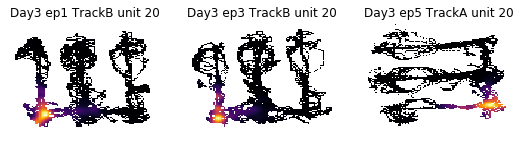

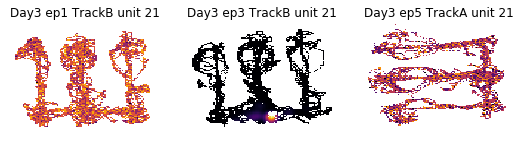

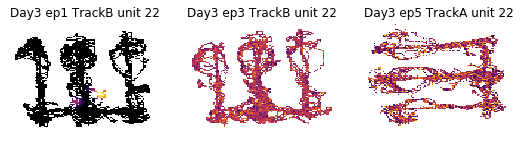

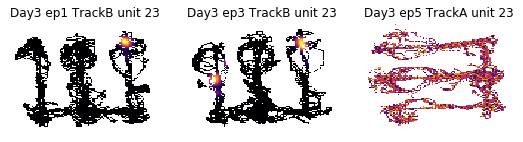

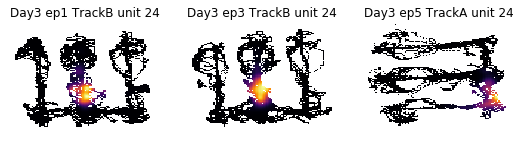

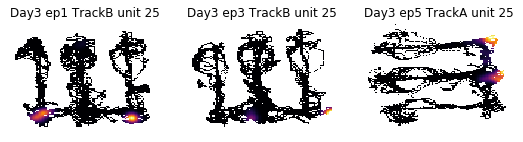

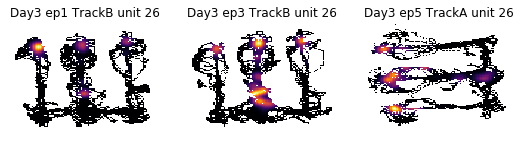

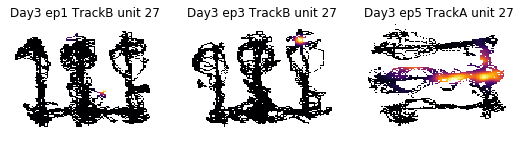

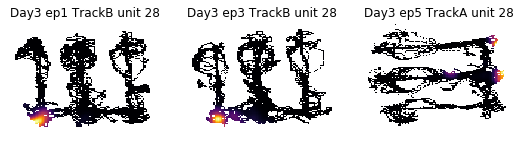

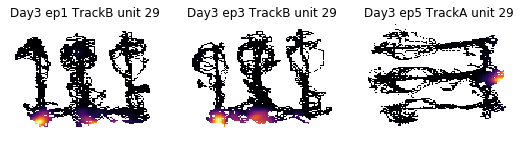

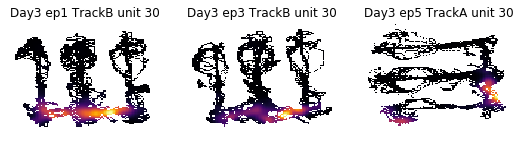

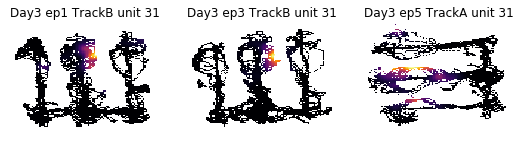

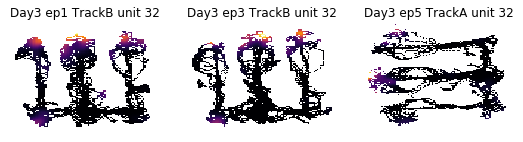

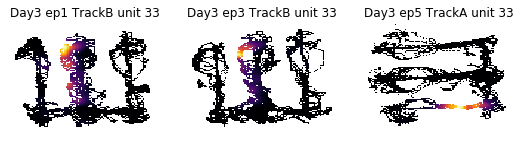

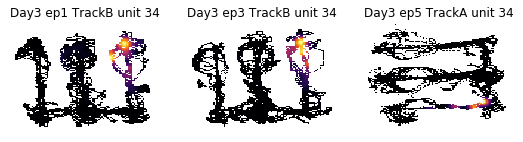

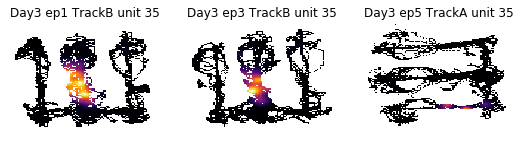

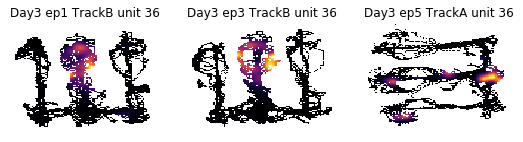

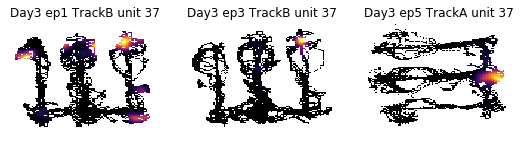

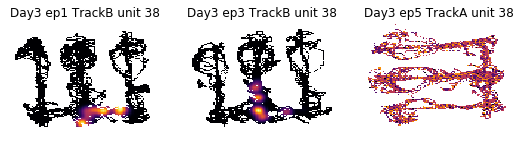

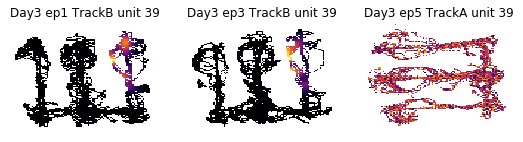

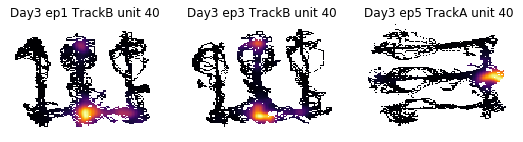

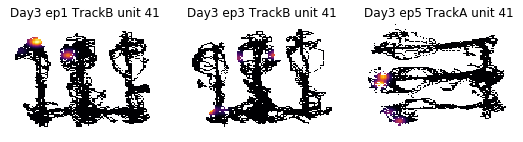

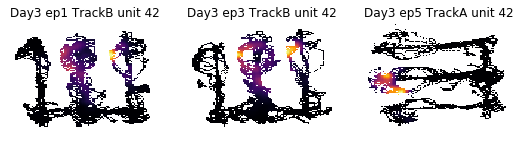

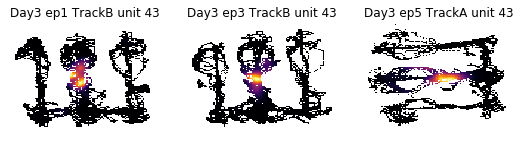

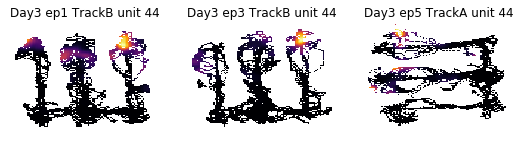

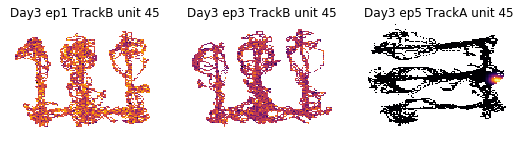

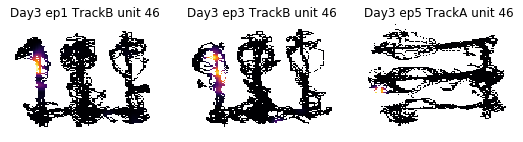

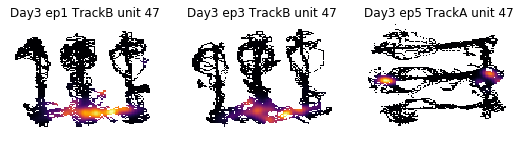

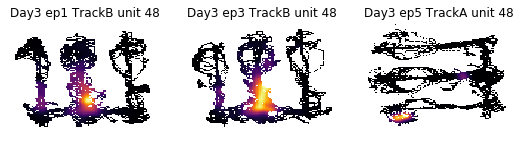

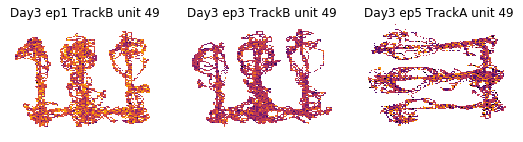

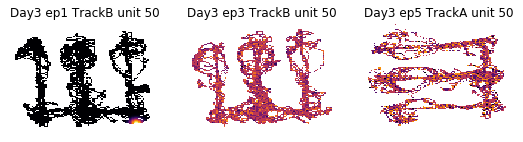

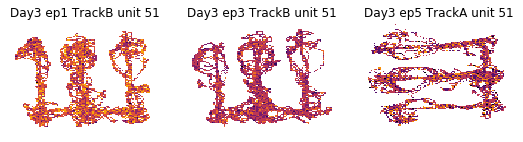

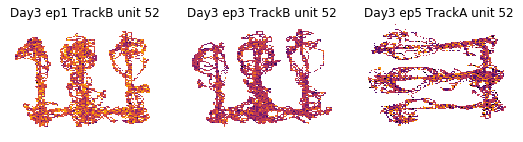

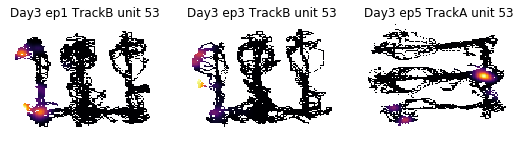

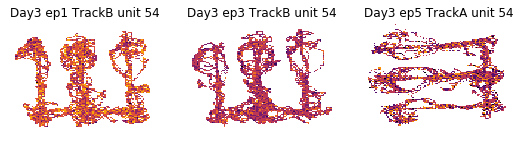

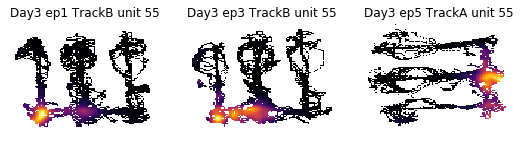

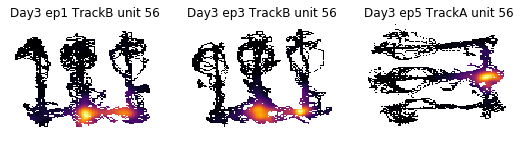

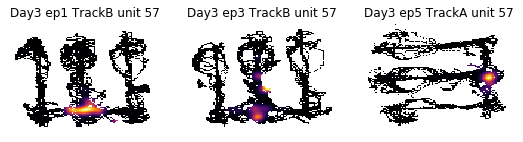

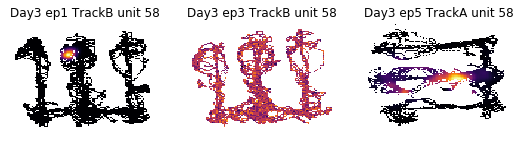

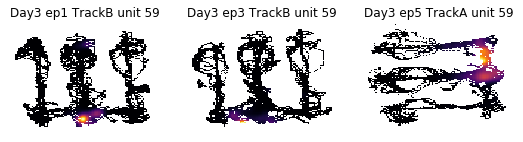

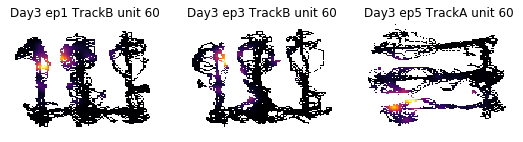

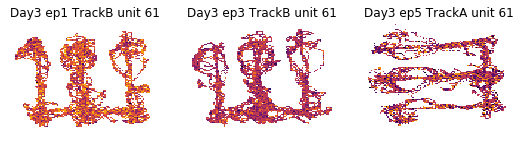

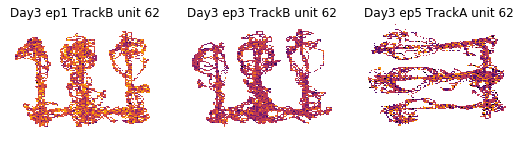

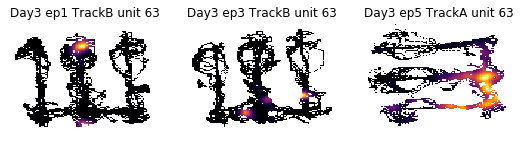

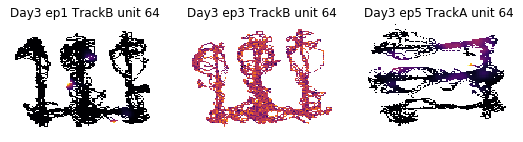

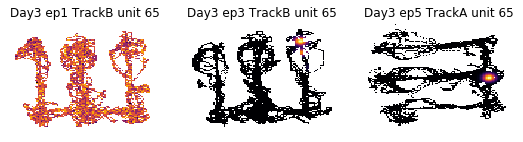

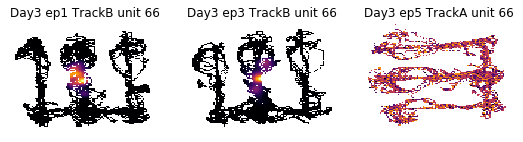

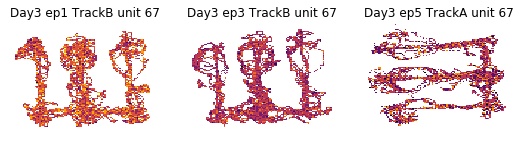

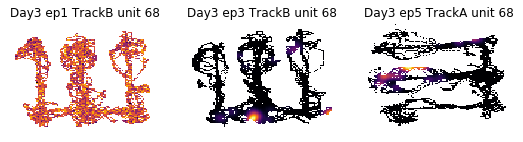

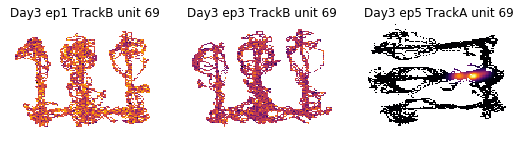

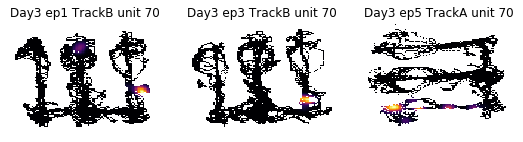

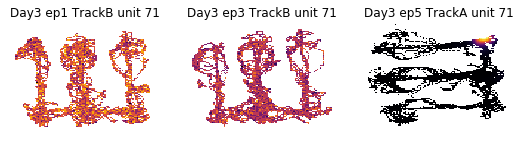

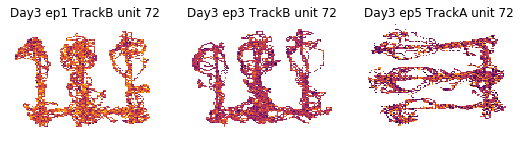

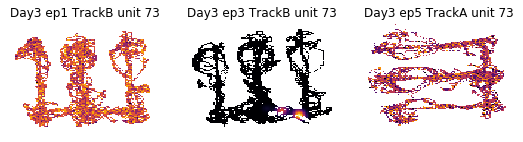

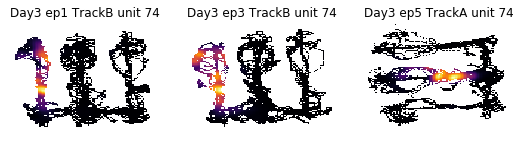

In [48]:
def plot_all_run_tuning_curves2D(data, animal, day, sigma_tc=3):

    task_run_epochs = data[animal][day]['task_metadata'].query('type=="run"').Epoch.values
    environments = data[animal][day]['task_metadata'].query('type=="run"').environment.values
    tuning_curves = data[animal][day]['tuning_curves2D']

    for unit in range(tuning_curves[task_run_epochs[0]].n_units):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2))
        axes = (ax1, ax2, ax3)

        for epidx, env, ax in zip(task_run_epochs, environments, axes):
            maxcbrate = 0.65*np.round(np.nanmax(tuning_curves[epidx].smooth(sigma=0).ratemap[unit,:,:])*10)/10
            _, img = npl.imagesc(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:].T, cmap=plt.cm.inferno, ax=ax)
            ax.set_title(str(day) + ' ep' + str(epidx) + ' ' + env + ' unit ' + str(unit+1))
            npl.utils.clear_left_right(ax)
            npl.utils.clear_top_bottom(ax)

        plt.show()
        
animal = 'Bon'
day = 'Day3'
sigma_tc = 3 # in cm

plot_all_run_tuning_curves2D(data=data, 
                             animal=animal,
                             day=day,
                             sigma_tc=sigma_tc)

### Augment data dict with awake and quiescent epochs

**WARNING** I don't fully understand the definition of awake periods yet!

In [4]:
raise NotImplementedError('Awake and quiescent periods have not been implemented yet!')

NotImplementedError: Awake and quiescent periods have not been implemented yet!

### Find putative interneurons based on spike widths and firing rates

In [13]:
raise NotImplementedError('Interneurons should be removed before identifying place cells!')

NotImplementedError: Interneurons should be removed before identifying place cells!

### Augment data dict with place cell IDs

Here we determine place cells based only on minimum peak firing rates.

**Note:** it might be a little more robust to estimate firing rates from the idealized position, becuase the problem of having a potentially small number of observations per bin is greatly reduced.

**Note:** although we didn't specify any "minimum duration" that the rat had to visit a bin before it was included, in effect there is a minimum that is imposed by the bin size of the BinnedSpikeTrainArray run data. Since we binned into 500 ms bins, anything smaller than that would have been excluded automatically.

**@Caleb:** would you agree with this approach? Small number of observations could also artificially inflate the estimated firing rates. The problem can partially be improved by requiring a minimum duration for which the animal must have visited each bin location before we estimate a rate for that location, but in 2D (even in the w-maze) with only 15 minutes of data, such an additional criterion might limit the data unneccessarily...

In [15]:
epidx = 1
sigma_tc = 0 # because 2D smoothing (and maybe 1D smoothing, too?) currently still lowers the firing rate artificially,
             # we apply no smoothing when estimating the peak firing rates here...

peak_rates_2d_no_min_duration = []
peak_rates_2d_ideal_no_min_duration = []
peak_rates_1d_co = []
peak_rates_1d_oo = []

mean_rates_2d_no_min_duration = []
mean_rates_2d_ideal_no_min_duration = []
mean_rates_1d_co = []
mean_rates_1d_oo = []

for unit in range(data[animal][day]['tuning_curves2D'][0].n_units):
    tuning_curves = data[animal][day]['tuning_curves2D']
    peak_rates_2d_no_min_duration.append(np.nanmax(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:]))
    mean_rates_2d_no_min_duration.append(np.nanmean(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:]))

    tuning_curves = data[animal][day]['tuning_curves2D_ideal']
    peak_rates_2d_ideal_no_min_duration.append(np.nanmax(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:]))
    mean_rates_2d_ideal_no_min_duration.append(np.nanmean(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:]))
    
    tuning_curves = data[animal][day]['tuning_curves1D_center']
    peak_rates_1d_co.append(np.nanmax(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:]))
    mean_rates_1d_co.append(np.nanmean(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:]))
    
    tuning_curves = data[animal][day]['tuning_curves1D_outer']
    peak_rates_1d_oo.append(np.nanmax(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:]))
    mean_rates_1d_oo.append(np.nanmean(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:]))

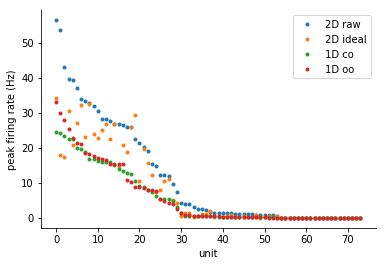

In [16]:
peakorder = np.argsort(peak_rates_2d_no_min_duration)[::-1]
plt.plot(np.array(peak_rates_2d_no_min_duration)[peakorder],'.', label='2D raw')
plt.plot(np.array(peak_rates_2d_ideal_no_min_duration)[peakorder],'.', label='2D ideal')
plt.plot(sorted(peak_rates_1d_co)[::-1],'.', label='1D co')
plt.plot(sorted(peak_rates_1d_oo)[::-1],'.', label='1D oo')
plt.xlabel('unit')
plt.ylabel('peak firing rate (Hz)')
plt.legend()
npl.utils.clear_right()
npl.utils.clear_top()

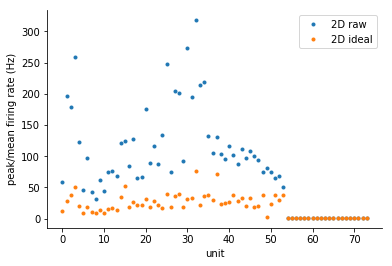

In [30]:
plt.plot(np.array(peak_rates_2d_no_min_duration)[peakorder]/np.array(mean_rates_2d_no_min_duration)[peakorder],'.', label='2D raw')
plt.plot(np.array(peak_rates_2d_ideal_no_min_duration)[peakorder]/np.array(mean_rates_2d_ideal_no_min_duration)[peakorder],'.', label='2D ideal')
plt.xlabel('unit')
plt.ylabel('peak/mean firing rate (Hz)')
plt.legend()
npl.utils.clear_right()
npl.utils.clear_top()
ax = plt.gca()


**Remarks:** It is important to note that in the above figure, the 2D units match exactly, but the 1D tuning curves were actually already re-ordered when we estimated them such that their units were ordered by peak location on the linearized track. We can do something fancier to figure out which units really matched up, but didn't do it here. Additionally, it may be worth re-making this figure using a different bin size (here 500 ms was used during tuning curve estimation) just as a sanity check that things remain largely unchanged.

In [62]:
min_firing_rate = 3 # minimum peak firing rate of place cells, in Hz
sigma_tc = 0 # no smoothing

for animal, day in sessions:
    data[animal][day]['PlaceCellIDs'] = dict()
    task_run_epochs = data[animal][day]['task_metadata'].query('type=="run"').Epoch.values
    tuning_curves = data[animal][day]['tuning_curves2D_ideal']
    for epidx in task_run_epochs:
        peak_firing_rates = []    
        for unit in range(tuning_curves[epidx].n_units):
            peak_firing_rates.append(np.nanmax(tuning_curves[epidx].smooth(sigma=sigma_tc).ratemap[unit,:,:]))

        data[animal][day]['PlaceCellIDs'][epidx] = np.argwhere(np.array(peak_firing_rates) > min_firing_rate).squeeze()

In [ ]:
# optionally find union of E1 cells

### Augment data dict with candidate SWR events

Here candidate SWRs must have associated running speeds of less than 2 cm/s, and must have a minimum of 5 place cells active in the corresponding context.

Also, we have at least

- E1a + E1b local candidates
- E2 local candidates*
- E2 remote candidates*  
- rest1 + rest2 E1 candidates
- final rest E1 candidates
- final rest E2 candidates

*[focus on these ones since I'm in a time crunch and don't fully understand "awake" defn yet]

In [98]:
ds_SWR = 0.015 # bin SWRs into 15 ms bins
min_n_active = 5 # minimum 5 place cells have to be active in an SWR event
max_speed = 2 # maximum [mean-]running speed for a candidate ripple to be considered
E1a, E1b, E2 = 1, 3, 5

for animal, day in sessions:
    all_candidate_SWRs_in_E2 = data[animal][day]['ripple_epochs'][data[animal][day]['task_epochs'][E2]]
    
    try:
        localPlaceCellIDs = data[animal][day]['PlaceCellIDs'][E2]
    except KeyError: # no E2 exists for this day...
        continue
    remotePlaceCellIDs = np.array(list(set(np.hstack((data[animal][day]['PlaceCellIDs'][E1a],
                                                      data[animal][day]['PlaceCellIDs'][E1b])))))
    
    # now restrict candidate SWRs to where the animal was largely immobile:
    speed = data[animal][day]['speed'][data[animal][day]['task_epochs'][E2]]
    speed_during_candidate_SWRs = speed[data[animal][day]['ripple_epochs'][data[animal][day]['task_epochs'][E2]]]

    mean_running_speed_per_ripple_event = []
    for snippet in speed_during_candidate_SWRs:
        mean_running_speed_per_ripple_event.append(snippet.mean())

    slow_ripple_IDs = np.atleast_1d(np.argwhere(np.array(mean_running_speed_per_ripple_event)<=max_speed).squeeze())

    all_candidate_SWRs_in_E2 = all_candidate_SWRs_in_E2[slow_ripple_IDs] # restricted to only those when animal is not running
    
    if all_candidate_SWRs_in_E2.isempty:
        print(animal, day, ' has no candidate SWRs; skipping...')
        continue
    bst_candidate_SWRs_all = data[animal][day]['spikes'][all_candidate_SWRs_in_E2].bin(ds=ds_SWR)
    bst_candidate_SWRs_local = data[animal][day]['spikes']._unit_subset(localPlaceCellIDs)[all_candidate_SWRs_in_E2].bin(ds=ds_SWR)
    bst_candidate_SWRs_remote = data[animal][day]['spikes']._unit_subset(remotePlaceCellIDs)[all_candidate_SWRs_in_E2].bin(ds=ds_SWR)
    
    n_active_local = []
    n_active_remote = []

    for snippet in bst_candidate_SWRs_local:
        n_active_local.append(snippet.n_active)

    for snippet in bst_candidate_SWRs_remote:
        n_active_remote.append(snippet.n_active)

    local_candidate_SWR_IDs = np.atleast_1d(np.argwhere(np.array(n_active_local) >= min_n_active).squeeze())
    remote_candidate_SWR_IDs = np.atleast_1d(np.argwhere(np.array(n_active_remote) >= min_n_active).squeeze())
    
    data[animal][day]['remote_replay_E1_in_E2'] = dict()
    data[animal][day]['remote_replay_E1_in_E2']['st_placecells_local'] = data[animal][day]['spikes']._unit_subset(localPlaceCellIDs)[data[animal][day]['task_epochs'][E2]]
    data[animal][day]['remote_replay_E1_in_E2']['st_placecells_remote'] = data[animal][day]['spikes']._unit_subset(remotePlaceCellIDs)[data[animal][day]['task_epochs'][E2]]
    data[animal][day]['remote_replay_E1_in_E2']['all_ripples'] = data[animal][day]['ripple_epochs'][data[animal][day]['task_epochs'][E2]]
    data[animal][day]['remote_replay_E1_in_E2']['bst_all_candidates'] = bst_candidate_SWRs_all
    data[animal][day]['remote_replay_E1_in_E2']['local_candidate_SWR_IDs'] = local_candidate_SWR_IDs
    data[animal][day]['remote_replay_E1_in_E2']['remote_candidate_SWR_IDs'] = remote_candidate_SWR_IDs
    data[animal][day]['remote_replay_E1_in_E2']['bst_local_candidates'] = bst_candidate_SWRs_all[local_candidate_SWR_IDs]
    data[animal][day]['remote_replay_E1_in_E2']['bst_remote_candidates'] = bst_candidate_SWRs_all[remote_candidate_SWR_IDs]

Fra Day2  has no candidate SWRs; skipping...
Fra Day3  has no candidate SWRs; skipping...
Fra Day4  has no candidate SWRs; skipping...
Fra Day6  has no candidate SWRs; skipping...


**Remarks:** We haven't extracted all the relevant info here yet (currently only looking for remote replay [of E1] when the animal is in E2), and I think the above data structure is getting a little clunky, so it might be better to split it off out of the data dict. This is a task for later though.

In [66]:
raise NotImplementedError('rest of the remote replay candidates should still be identified!')

NotImplementedError: rest of the remote replay candidates should still be identified!

### Save augmented data

In [101]:
FrankLabData = nel.ResultsContainer(data=data,
                                    sessions=FrankLabData.sessions,
                                    cellinfo=FrankLabData.cellinfo,
                                    taskinfo=FrankLabData.taskinfo,
                                    tetinfo=FrankLabData.tetinfo,
                                    description=FrankLabData.description)

FrankLabData.save_pkl(fileroot + 'FrankLabData-BonConFra-no-eeg03b.nel')

## Supplemental: Determine good parameters for tuning curve estimation (using cross-validation)

Here, I have [manually] varied the bin size for run epochs, as well as the spike smoothing standard deviation, and the nx and ny for the 2D tuning curves. The running bin size and amount of spike smoothing both had significant effects, and bin size = 500 ms, with 500 ms spike smoothing (applied on 25 ms sub-bins) worked well.

For animal `Bon`, day 3, epoch 1 (a run epoch), and with running bouts defined as velocity > 3 pixels/s reverting down to 2.5 pixels/s, these parameters gave a median test decoding accuracy of 6.3 cm, and a median train decoding accuracy of ?? cm. This is the only session (epoch) in which I tried to optimize the parameters, but these same parameters had the following accuracies (median decoding error, in pixels) for two other epochs:

 - day 3, epoch 3 [same track], train / test: 1.0 / 5.0  [old values now, ripples were recomputed, so need to update!]
 - day 3, epoch 5 [different track], train / test: 1.2 / 5.9 [old values now, ripples were recomputed, so need to update!]
 
**Note:** interestingly, the tuning curve smoothing also made a big (negative!) difference. We obtained much better results when not smoothing at all!

**Food for thought:** using a larger bin size (500 ms here), we get more accurate results. In effect, we are reducing our estimator variance, which improves generalization accuracy. However, the occcupancy map then looks a little sparse, since we have much fewer bin visits than if we had used a shorter bin size. If we want to visualize the tuning curves, then we can either smooth across all possible grid points, but a more principled approach is actually to only smooth within those bins where the animal actually ran through. Therefore, the longer temporal bin size has a positive effect on our decoding accuracy, but a negative effect on our occupancy estimation. It might be worth to somehow get an additional `occupancy` into the tuning curve, for visualization and smoothing.

Unfortunately, there is great risk of confusion, since the firing rates are calculated using the 500 ms bin occupancy (as it should be), but then subsequently we may want to smooth and redistribute those firing rates using the finer-grained occupancy obtained with a shorter temporal bin size.

Maybe we should call this second occupancy the `mask` or something like that, since we will mask out all grid points where the animal was never observed running, when we do the tuning curve smoothing and visualization. Indeed, it may be the best to find the mask from the `pos` object, during ALL types of activity (running or otherwise), instead of estimating the mask simply from running bouts.

**Update:** the mask functionality has now been integrated into `TuningCurve2D`, but `nel.decoding` has not yet been extended to deal properly with the `NaN`s. However, there's an easy fix, by calling
```
tc2d._ratemap[tc2d.ratemap!=tc2d.ratemap] = 0.001
```

In [14]:
animal, day = 'Bon', 'Day3'
epidx = 1 # first run epoch

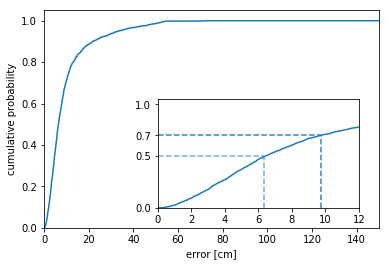

6.407142857142857


In [19]:
#####################################################################################
## Cross validated decoding accuracy
#####################################################################################

#####################################################################################
## extract RUN epochs excluding any ripple epochs
#####################################################################################

ds_run = 0.5 # 500 ms bins for RUN data
ds_25ms = 0.025

pos = data[animal][day]['pos'][epidx]
ripple_epochs = data[animal][day]['ripple_epochs']
run_epochs = data[animal][day]['run_epochs']
st = data[animal][day]['spikes'][epidx]
st_run_no_ripples = st[run_epochs][~ripple_epochs]

# smooth and re-bin:
sigma = 0.5 # 500 ms spike smoothing
bst_run_no_ripples = st_run_no_ripples.bin(ds=ds_25ms).smooth(sigma=sigma, inplace=True).rebin(w=round(ds_run/ds_25ms))

#####################################################################################
## 
#####################################################################################
from nelpy.decoding import k_fold_cross_validation

k_folds = 5
X = [ii for ii in range(bst_run_no_ripples.n_epochs)]

ext_xmin, ext_xmax = np.floor(pos[:,0].min()/10)*10, np.ceil(pos[:,0].max()/10)*10
ext_ymin, ext_ymax = np.floor(pos[:,1].min()/10)*10, np.ceil(pos[:,1].max()/10)*10

ext_nx=100
ext_ny=100

# for decoding:
max_error = 150
n_bins = 2000
hist = np.zeros(n_bins)

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     

    run_train = bst_run_no_ripples[training]
    run_test = bst_run_no_ripples[validation]
    
    # learn tuning curves on training set
    # ===================================
    
    tc2d = nel.TuningCurve2D(bst=run_train,
                             extern=pos,
                             min_duration=0, 
                             ext_nx=ext_nx, 
                             ext_ny=ext_ny, 
                             ext_xmin=ext_xmin, 
                             ext_xmax=ext_xmax, 
                             ext_ymin=ext_ymin, 
                             ext_ymax=ext_ymax)
    tc2d = tc2d.smooth(sigma=sigma_tc*0)

    # evaluate decoding performance on validation / test set
    # ========================================================
        
    target = pos.asarray(at=run_test.bin_centers).yvals
    
    posterior, lengths, mode_pth, mean_pth = nel.decoding.decode2D(run_test, tc2d)

    hist_, bins = np.histogram(
        np.sqrt(((mean_pth - target)**2).sum(axis=0)),
        bins=n_bins,
        range=(0, max_error))
        
    hist += hist_

# build cumulative error distribution
cumhist = np.cumsum(hist)
cumhist = cumhist / cumhist[-1]
bincenters = (bins + (bins[1] - bins[0])/2)[:-1]

# modify to start at (0,0):
cumhist = np.insert(cumhist, 0, 0)
bincenters = np.insert(bincenters, 0, 0)

# modify to end at (max_error,1):
cumhist = np.append(cumhist, 1)
bincenters = np.append(bincenters, max_error)

median_error = np.interp(x=0.5, # median
          xp=[float(cumhist[np.argwhere(cumhist > .5)[0]-1]), float(cumhist[np.argwhere(cumhist > .5)[0]])],
          fp=[float(bincenters[np.argwhere(cumhist > .5)[0]-1]), float(bincenters[np.argwhere(cumhist > .5)[0]])])

ax, axi = npl.plot_cum_error_dist(cumhist=cumhist, bincenters=bincenters, label='tuning curves');
plt.show()

print(median_error)

In [49]:
# Assess 1D decoding accuracy with cross-validation
raise NotImplementedError
with npl.FigureManager(show=showfig, figsize=(5,5)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    
    ds_run = 0.5 # 100 ms
    ds_1ms = 0.01
    st_run = st[run_epochs1 + run_epochs2]

    # smooth and re-bin:
    bst_run = st_run.bin(ds=ds_1ms).smooth(sigma=0.5, inplace=True).rebin(w=ds_run/ds_1ms)
    
    bst = bst_run

    cumhist, bincenters = nel.decoding.cumulative_dist_decoding_error_using_xval(bst, extern=pos, extmax=225)
    npl.plot_cum_error_dist(bst=bst, extern=pos, extmin=0, extmax=225);
    
#     npl.utils.savefig('cum_error.svg')

NotImplementedError: 